# Basic Logistic Regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
gasoline_proc = pd.read_csv('../../data/03_processed/gasoline_processed.csv')
astm = pd.read_csv('../../data/01_raw/ASTM_fuel.csv')
astm.columns = ['Date', 'TN_retailers_seasons', 'TN_distributor_seasons',
       'vapor_liquid_minC_retail', 'distillation_50_minC _retail',
       'distillation_50_maxC_retail', 'vapor_pressure_maxC_retail',
       'vapor_liquid_minC_dist', 'distillation_50_minC_dist',
       'distillation_50_maxC_dist', 'vapor_pressure_maxC_dist']

In [3]:
for col in astm.columns: 
    try:
        astm[col] = astm[col].str.strip()
    except AttributeError: 
        pass

In [4]:
gasoline_proc['datesampled'] = pd.to_datetime(gasoline_proc['datesampled'])

In [5]:
gasoline_proc.dropna(subset=['grade'], inplace=True)

In [6]:
gasoline_proc['datesampled_month'] = gasoline_proc.datesampled.dt.month
gasoline_proc['datesampled_day'] = gasoline_proc['datesampled'].dt.day
gasoline_proc['datesampled_month_day'] = gasoline_proc['datesampled_month'].astype('str') + '/' + gasoline_proc['datesampled_day'].astype('str')

In [7]:
gasoline_proc.rename(columns={'datesampled_month_day':'Date'}, inplace=True)

In [8]:
gasoline_proc = gasoline_proc.merge(astm, 
               how='left', 
                on='Date'
               )

In [9]:
gasoline_proc.drop(columns=['zipcode'], inplace=True)

In [10]:
gasoline_proc.dropna(inplace=True)

In [11]:
gasoline_proc.reset_index(inplace=True, drop=True)

**Possible Predictor Variables**

1. TN_retailers_seasons
1. TN_distributor_seasons
1. grade
1. supplier

**Possible Target Variable**
1. compliance_dist_50
1. compliance_vap_pressure
1. compliance_vap_liq_pressure

## Compliance vapor liquid pressure ~ TN Retailers Season & Grade (Statsmodel) 

In [12]:
# construct features 
x_feats = ['TN_retailers_seasons', 'grade']
X = pd.get_dummies(gasoline_proc[x_feats], dtype=float)
X = sm.tools.add_constant(X)
# convert target using get_dummies
y = pd.get_dummies(gasoline_proc["compliance_vap_liq_pressure"], dtype=float)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,0], test_size=0.3, random_state=0)

```python
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)
```

```python
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
```

In [14]:
smote = SMOTE()

# simple resampling from your previously split data
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train.ravel())

```python
print("After OverSampling, counts of label '1': {}".format(sum(y_train_resampled==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_resampled==0)))
```

In [15]:
# Your code here
import statsmodels.api as sm
logit_model = sm.Logit(y_train_resampled, X_train_resampled)
result = logit_model.fit()

         Current function value: 0.388677
         Iterations: 35


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
result.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                18110
Model:                          Logit   Df Residuals:                    18099
Method:                           MLE   Df Model:                           10
Date:                Wed, 31 Jul 2019   Pseudo R-squ.:                  0.4393
Time:                        04:23:45   Log-Likelihood:                -7038.9
converged:                      False   LL-Null:                       -12553.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.0468        nan        nan        nan         nan         nan
x1           -11.2656   4.13e+05  -2.73e-05      1.000    -8.1e+05     8.1e+05
x2           -10.8360   4.13e+05  -2.62e-05      1.000    -8.1e+05     8.1e+05
x3            12.4978   4.13e+05   3.03e-05      1.000    -8.1e+05     8.1e+05
x4            13.3988   4.13e+05   3.24e-05      1.000    -8.1e+05     8.1e+05
x5           -11.3101   4.13e+05  -2.74e-05      1.000    -8.1e+05     8.1e+05
x6            13.7167   4.13e+05   3.32e-05      1.000    -8.1e+05     8.1e+05
x7            -8.8030   4.13e+05  -2.13e-05      1.000    -8.1e+05     8.1e+05
x8           -12.4455   4.13e+05  -3.01e-05      1.000    -8.1e+05     8.1e+05
x9             1.6079        nan        nan        nan         nan         nan
x10            1.8684        nan        nan        nan         nan         nan
x11          -21.4028        nan        nan        nan         nan         nan
x12            2.8795        nan        nan        nan         nan         nan
==============================================================================

Possibly complete quasi-separation: A fraction 0.29 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Let's see how our test model did

## Compliance vapor liquid pressure ~ TN Retailers Season & Grade (sklearn) 

We are trying to predict those that fail the test

In [17]:
# construct features 
x_feats_skl = ['TN_retailers_seasons', 'grade']
X_skl = pd.get_dummies(gasoline_proc[x_feats], dtype=float)
# convert target using get_dummies
y_skl = pd.get_dummies(gasoline_proc["compliance_vap_liq_pressure"], dtype=float)

In [18]:
X_train_skl, X_test_skl, y_train_skl, y_test_skl = train_test_split(X_skl, y_skl, random_state=0)

In [19]:
smote = SMOTE()

# simple resampling from your previously split data
X_train_resampled_skl, y_train_resampled_skl = smote.fit_sample(X_train_skl, y_train_skl.iloc[:,0])

In [20]:
smote = SMOTE()

# simple resampling from your previously split data
X_test_resampled_skl, y_test_resampled_skl = smote.fit_sample(X_test_skl, y_test_skl.iloc[:,0])

In [21]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train_resampled_skl, y_train_resampled_skl)
model_log

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Predict

In [22]:
y_hat_test_resampled = logreg.predict(X_test_resampled_skl)
y_hat_train_resampled = logreg.predict(X_train_resampled_skl)

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [24]:
print('Training Precision: ', precision_score(y_hat_train_resampled, y_train_resampled_skl))
print('Testing Precision: ', precision_score(y_hat_test_resampled, y_test_resampled_skl))
print('\n\n')

print('Training Recall: ', recall_score(y_hat_train_resampled, y_train_resampled_skl))
print('Testing Recall: ', recall_score(y_hat_test_resampled, y_test_resampled_skl))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_hat_train_resampled, y_train_resampled_skl))
print('Testing Accuracy: ', accuracy_score(y_hat_test_resampled, y_test_resampled_skl))
print('\n\n')

print('Training F1-Score: ',f1_score(y_hat_train_resampled, y_train_resampled_skl))
print('Testing F1-Score: ',f1_score(y_hat_test_resampled, y_test_resampled_skl))

Training Precision:  0.9269147510565922
Testing Precision:  0.6313349814585909



Training Recall:  0.7221909886756084
Testing Recall:  0.6500159083678014



Training Accuracy:  0.785176785898361
Testing Accuracy:  0.6457045735475896



Training F1-Score:  0.8118454315637416
Testing F1-Score:  0.6405392694779746


### ROC Curve & AUC

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
#First calculate the probability scores of each of the datapoints:
y_score = logreg.fit(X_train_resampled_skl, y_train_resampled_skl).decision_function(X_test_resampled_skl)

fpr, tpr, thresholds = roc_curve(y_test_resampled_skl, y_score)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [37]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7778175569649844


AUC: 0.7778175569649844


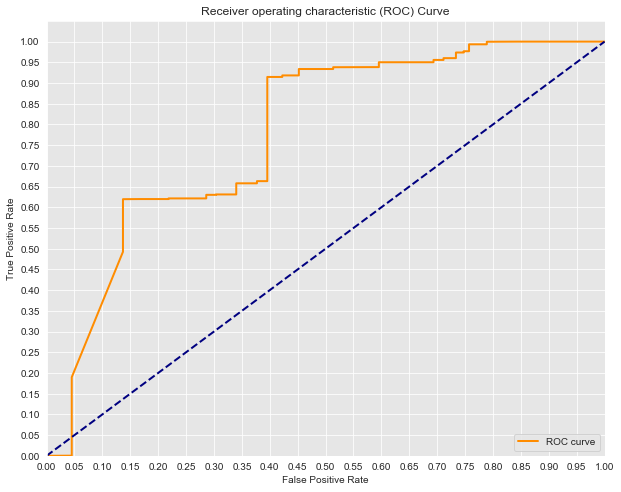

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<font color='red'>Do a lasso regression to get rid of the coefficients that aren't adding any value</font>

Look at smaller number of suppliers (look at histogram of suppliers and see if there is some one t

**See if there are suppliers that dominate the field**

In [25]:
print('Number of unique Suppliers: ', gasoline_proc['supplier'].nunique())

Number of unique Suppliers:  622


In [26]:
supplier_facilitycount = gasoline_proc.groupby(['supplier']).count()['facilityname'].to_frame()

In [27]:
supplier_facilitycount.reset_index(inplace=True)

In [28]:
supplier_facilitycount.rename(columns={'facilityname':'facilitycount'}, inplace=True)

In [29]:
supplier_facilitycount.sort_values(['facilitycount'], ascending=False).head(10)

,supplier,facilitycount
593,Valero,502
446,NFRY-AKVRCW,472
177,Hollingsworth Oil Company,408
492,NFRY-AKVREE,406
494,NFRY-AKVREG,316
134,Exxonmobil,306
589,Tri-star Energy,265
464,NFRY-AKVRDG,263
479,NFRY-AKVRDX,259
600,Willoughby Oil Company,213


**Let's make a new dataframe with only the top 5 values**

In [30]:
gas_reduced_supplier = gasoline_proc.loc[(gasoline_proc['supplier']=='Valero') 
                  | (gasoline_proc['supplier']=='NFRY-AKVRCW') 
                  | (gasoline_proc['supplier']=='Hollingsworth Oil Company') 
                  | (gasoline_proc['supplier']=='NFRY-AKVREE') 
                  | (gasoline_proc['supplier']=='NFRY-AKVREG') 
                  | (gasoline_proc['supplier']=='Exxonmobil') 
                  | (gasoline_proc['supplier']=='Tri-star Energy') 
                  | (gasoline_proc['supplier']=='NFRY-AKVRDG') 
                  | (gasoline_proc['supplier']=='NFRY-AKVRDX') 
                  | (gasoline_proc['supplier']=='Willoughby Oil Company')]

In [31]:
gas_reduced_supplier.reset_index(drop=True, inplace=True)